# ch05.05. 기초모델 구현 - Adaline
---
* 날짜: 2022.05.16
* 이름: 윤태우

## 학습내용
    - 이진 분류 개념에 대해 이해한다.
    - Adaline 프로세스를 이해한다. 
    - Adaline 알고리즘을 구현한다.
    - 경사하강법에 대해 이해한다.

```
import numpy as np
import matplotlib.pyplot as plt
```

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## 클래스 작성
---

In [2]:
class AdalineGD():
  def __init__(self, lr=0.001, random_state=1):
    self.lr=lr                                        # 학습률 설정
    self.seed = np.random.RandomState(random_state)   # 난수 생성(seed = random_stats)

  def init_weights(self, X):
    size = X.shape[1]                   # 데이터 X의 열(feature) 개수에 따라 w를 설정 ex) 행렬 2X3 과 w 를 내적하기 위해서는 w도 3Xn이 되어야 하기 때문
    self.w = self.seed.normal(0,0.01, size = size +1)   # bias(편향)이 있으므로 size = X의 feature 수 +1

  def model(self, X):
    return np.dot(X,self.w[:-1])+ self.w[-1]       # w[-1]은 bias 이므로 그 전까지 w값을 X와 내적하고, 각 값에 bias를 더해 예측값을 리턴하도록 설정

  def predict(self, X):
    y_hat = self.model(X)                      
    logit = np.where(y_hat >= 0.5, 1, 0)           # 예측값 y_hat을 0 또는 1로 이진분류
    return logit

  def loss(self, y, y_hat):
    return np.sum(((y-y_hat)**2)/2)                # 손실함수 L(w)를 계산하기 위해서는 i번째 샘플의 결과값 y와 예측값 y의 차이가 필요하다.
    
  def accuracy(self, y, y_logit):
    return np.count_nonzero(y == y_logit)/len(y)     # 정확도 = 예측과 결과가 일치 하는 수 / 전체 결과값 수 이다. (y == y_hat이면 True로 1인데, count로 1의 개수를 세면 총 일치하는 경우의 수를 말한다.) 

  def evaluate(self, X, y):
    y_hat = self.model(X)
    y_logit = self.predict(X)
    loss = self.loss(y,y_hat)  # loss
    loss = loss.sum()/len(y)   # loss의 평균
    acc = self.accuracy(y,y_logit) # acc = 정확도
    return loss, acc

  def fit(self, X, y, epochs=10, show_params=False):

    self.init_weights(X) # 가중치 초기화
    self.history=dict(loss=[], acc=[]) # history 초기화

# 최적화
    for epoch in range(epochs):                # 최적화 시행 횟수에 따라 w 값이 변함.
      for xi, yi in zip(X, y) :
        y_hat = self.model(xi)                 # i번째 샘플의 예측값
        self.w[:-1] += self.lr*np.sum(np.dot(xi.T, (yi-y_hat))) # 파라미터 w의 값은 (w의 j번째 feature - 학습률* 손실의 변화율) 으로 점점 업데이트 될것.
                                                   # 1/2 sigma (y-y_hat)^2 을 미분하면 1/2 * 2 * (y-xiwj)(-xi) 이다. 1/2 *2 = 1, -(y-xiwj)(xi) = -(y-y_hat)(xi) 즉, wj:= wj + rl*(y-y_hat)(xi)
                                                   # xi 는 샘플 한 줄 [1,2,3,4]이고, 결과값 yi-y_hat = [0,0,0,0]이다. 따라서 내적을 하기 위해서는 xi.T로 트랜스포즈를 해줘야한다.
        self.w[-1] += self.lr*np.sum(y-y_hat)                       # 학습률이 올라감에 따라 예측값과 실제 y 값 사이의 차이가 적어질것. 따라서 bias 의 값을 예측값과 실제값의 차이로 설정해 점점 같아지도록 함.
                                                  
      
      # 평가 및 결과 저장
      loss, acc = self.evaluate(X, y)
      self.history['loss'].append(loss)         # key값만 지정되어 있는 딕셔너리 history에 각각 key값에 value들을 넣어준다.
      self.history['acc'].append(acc)
      print(f'[Epoch {epoch}] loss: {np.round(loss,2)}  acc: {np.round(acc,2)}')   # epoch (최적화 시행횟수)에 따라 변하는 loss, acc(정확도)를 출력해준다.
      if show_params: print(self.w)


  # 데이터 흐름 시각화
  def draw_dflow(self, X, y, title='', figsize=(8,4)):
    y_hat = self.model(X)
    y_pred = self.predict(X)

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(y, label='y', marker='o')
    plt.plot(y_hat, label='$\hat{y}$', marker='.', linestyle='--')
    plt.plot(y_pred, label='$\logit$', marker='.', linestyle='--')
    plt.legend()
    plt.show()

  # 학습 곡선 시각화
  def draw_lcurve(self, title='', figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(self.history['acc'], label='acc', marker='o')
    plt.plot(self.history['loss'], label='loss', marker='o')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

## Iris 데이터로 분류 진행
---

### **데이터 로드**

In [3]:
# 데이터 불러오기

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
  
def mpg_loader(test_size=0.2, rs=1):
  df = sns.load_dataset('mpg')
  print('===== 데이터 확인 ====')
  print('* shape: ',df.shape)
  print(df.head())

  print('===== 범주 자료 제거 ====')
  df = df.drop(['origin', 'name'], axis=1)
  print('* shape: ',df.shape)

  print('===== 결측치 제거 ====')
  df = df.dropna(axis=0)
  print('* shape: ',df.shape)

  print('===== 정규화 ====')
  df=df.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
  print(df.head())

  print('===== 넘파이 변환 ====')
  ds = df.to_numpy()
  X, y = df[:, 1:], df[:, 0]
  print(X.shape, y.shape)

  print('===== 데이터 분할 ====')

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rs)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test



from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

def iris_loader(c_1, c_not1, test_size=0.2, rs=1):
  iris = load_iris()
  X = iris.data
  y = iris.target

  X = X[y!=2]
  y = y[y!=2]
  y = np.where(y==1, c_1, c_not1)
  print(X.shape, y.shape, X[0], y[0])

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rs)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = iris_loader(1, 0)

(100, 4) (100,) [5.1 3.5 1.4 0.2] 0
(75, 4) (25, 4) (75,) (25,)


### **학습전 성능 평가**

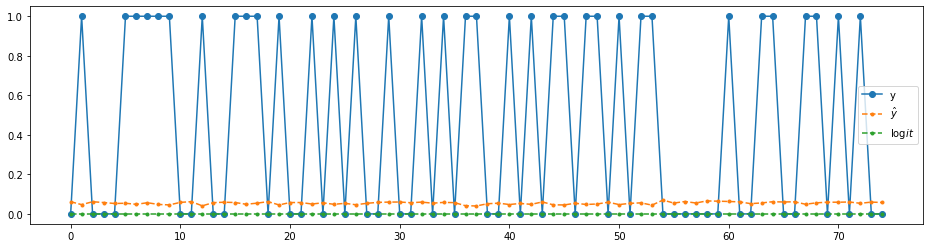

성능:  (0.21108347124931862, 0.5333333333333333)


In [5]:
model = AdalineGD()

model.init_weights(X_train)
model.draw_dflow(X_train, y_train, figsize=(16,4))
print('성능: ', model.evaluate(X_train, y_train))

### **학습**

In [6]:
history = model.fit(X_train, y_train, epochs=20, show_params=True)

[Epoch 0] loss: 0.09  acc: 0.95
[ 0.03026709  0.0707306   0.04567041  0.05647287 -0.08445998]
[Epoch 1] loss: 0.07  acc: 0.96
[ 0.04987113  0.09033464  0.06527445  0.07607691 -0.31972432]
[Epoch 2] loss: 0.06  acc: 0.96
[ 0.06669188  0.10715538  0.08209519  0.09289765 -0.52158688]
[Epoch 3] loss: 0.05  acc: 0.96
[ 0.08112449  0.12158799  0.0965278   0.10733026 -0.69478991]
[Epoch 4] loss: 0.04  acc: 0.96
[ 0.09350802  0.13397152  0.10891134  0.1197138  -0.84340235]
[Epoch 5] loss: 0.04  acc: 0.96
[ 0.1041334   0.1445969   0.11953671  0.13033917 -0.97091547]
[Epoch 6] loss: 0.04  acc: 0.96
[ 0.11325023  0.15371373  0.12865355  0.13945601 -1.08032484]
[Epoch 7] loss: 0.03  acc: 0.96
[ 0.12107269  0.1615362   0.13647601  0.14727847 -1.17420077]
[Epoch 8] loss: 0.03  acc: 0.96
[ 0.12778456  0.16824806  0.14318788  0.15399034 -1.25474861]
[Epoch 9] loss: 0.03  acc: 0.96
[ 0.13354351  0.17400701  0.14894682  0.15974928 -1.32386063]
[Epoch 10] loss: 0.03  acc: 0.96
[ 0.13848482  0.17894833  0

### **학습 후 성능평가**

성능:  (0.025004286006988737, 0.96)


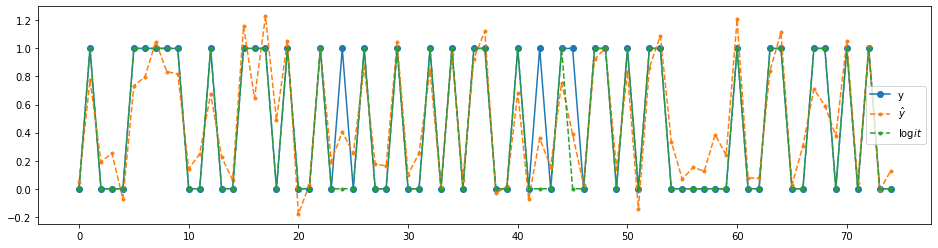

In [7]:
print('성능: ', model.evaluate(X_train, y_train))
model.draw_dflow(X_train, y_train, figsize=(16,4))

### **테스트셋 성능평가**

성능:  (0.037374560519528456, 0.96)


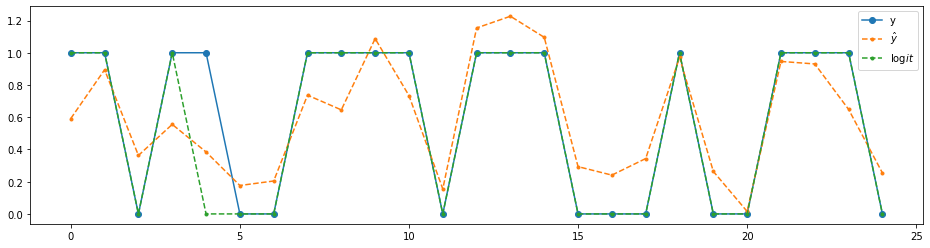

In [8]:
print('성능: ', model.evaluate(X_test, y_test))
model.draw_dflow(X_test, y_test, figsize=(16,4))

### **학습곡선**

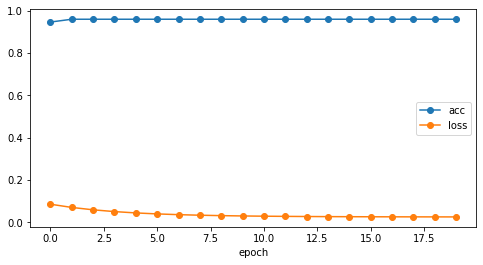

In [9]:
model.draw_lcurve()

### **하이퍼파라미터에 따른 성능평가**

In [12]:
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
  model = AdalineGD(lr=lr)
  history = model.fit(X_train, y_train, epochs=10)
  print(f'===== lr {lr} ==== {model.evaluate(X_test, y_test)}')

  # 학습률 0.0001 일때 가장 정답률이 높다. loss도 가장 낮다.

[Epoch 0] loss: 0.18  acc: 0.53
[Epoch 1] loss: 0.16  acc: 0.53
[Epoch 2] loss: 0.14  acc: 0.53
[Epoch 3] loss: 0.13  acc: 0.53
[Epoch 4] loss: 0.12  acc: 0.53
[Epoch 5] loss: 0.12  acc: 0.53
[Epoch 6] loss: 0.11  acc: 0.53
[Epoch 7] loss: 0.11  acc: 0.53
[Epoch 8] loss: 0.11  acc: 0.59
[Epoch 9] loss: 0.1  acc: 0.65
===== lr 1e-05 ==== (0.11463860604384274, 0.56)
[Epoch 0] loss: 0.1  acc: 0.63
[Epoch 1] loss: 0.1  acc: 0.96
[Epoch 2] loss: 0.1  acc: 0.95
[Epoch 3] loss: 0.09  acc: 0.95
[Epoch 4] loss: 0.09  acc: 0.95
[Epoch 5] loss: 0.09  acc: 0.95
[Epoch 6] loss: 0.09  acc: 0.95
[Epoch 7] loss: 0.09  acc: 0.95
[Epoch 8] loss: 0.08  acc: 0.95
[Epoch 9] loss: 0.08  acc: 0.95
===== lr 0.0001 ==== (0.08790461562001034, 0.96)
[Epoch 0] loss: 0.08  acc: 0.95
[Epoch 1] loss: 0.07  acc: 0.96
[Epoch 2] loss: 0.06  acc: 0.96
[Epoch 3] loss: 0.05  acc: 0.96
[Epoch 4] loss: 0.04  acc: 0.96
[Epoch 5] loss: 0.04  acc: 0.96
[Epoch 6] loss: 0.04  acc: 0.96
[Epoch 7] loss: 0.03  acc: 0.96
[Epoch 8] l